<a href="https://colab.research.google.com/github/Bernat-Jorda-Carbonell/TDA_projects/blob/main/circular_coordinates/TDA_circular_coordinates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Warm Up.
We will start by importing the packages used. The first line is commented to not reinstall ripser every time.

In [ ]:
!pip install ripser
import matplotlib as mpl
# this is to fix a "no tex found" problem that was rising up and a link to where I found the fix
# https://stackoverflow.com/questions/58121461/runtimeerror-failed-to-process-string-with-tex-because-latex-could-not-be-found
mpl.rcParams.update(mpl.rcParamsDefault)


import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.1 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18102 sha256=b9c8857444f0f659e7ee291be63b20ac792eb39ed6e28d2b8cfd3967267a6587
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


The code copied from the ripser example, just the functions defined

In [143]:
# from https://ripser.scikit-tda.org/en/latest/notebooks/Representative%20Cocycles.html

def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], linewidth = 3)

def plotCocycle2D(D, X, cocycle, thresh):
    """
    Given a 2D point cloud X, display a cocycle projected
    onto edges under a given threshold "thresh"
    """
    #Plot all edges under the threshold
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    #Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')
    #Plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')

Instead of the 12 points in a noisy circle, we use the code to sample 20 points from the circle

In [144]:
np.random_seed=9
N=20
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)]) + 0.4*np.random.random((N,2))


And we run ripser, turning on a flag that indicates that we want to store the cocycles, and doing the computation over the field $\mathbb{Z}_{17}$ as it does in the ripser example (it is a better idea to change "coeff" value from 17 to 41)

In [145]:
result = ripser(x, coeff=17, do_cocycles=True)
diagrams = result['dgms']
cocycles = result['cocycles']
D = result['dperm2all']

Now find the index of the maximum persistence point in the diagram and highlight that point with a black x. This is the point of which we are asked to project the representative cocycle.

<ipython-input-146-0ed207447add>:4: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')


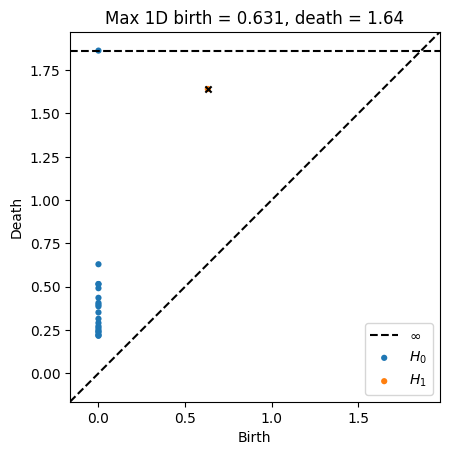

In [146]:
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

we will jumpt to the code of the example that project the representative cocycle of that point onto the edges present *right before* the feature vanishes. (we moved the line of code where it defines cocycle from the part of code that we don't use to here)

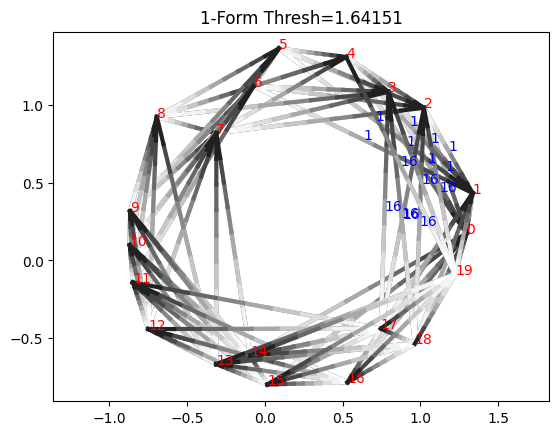

In [147]:
cocycle = cocycles[1][idx]
thresh = dgm1[idx, 1]-0.00001 #Project cocycle onto edges less slightly less than the death time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()

Now we will project onto the edges present right after its birth

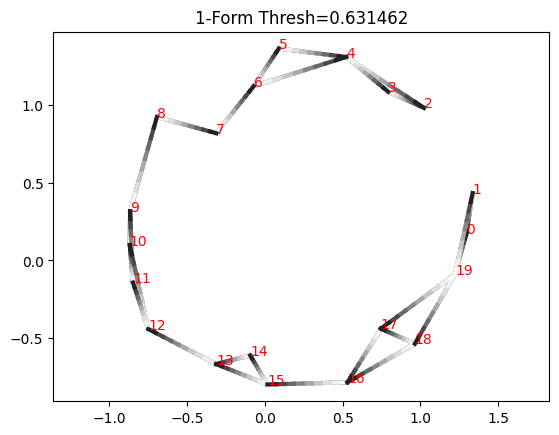

In [148]:
thresh = dgm1[idx, 0] #Project cocycle onto edges that have lengths less than or equal to the birth time
plotCocycle2D(D, x, cocycle, thresh)
plt.title("1-Form Thresh=%g"%thresh)
plt.show()

#Implementation
Now we are going to go over the 7 steps of the algorithm. Since the implementation asks for distance matrix $D$, cocycle $\alpha$, a treshold $r$ and a prime $p$, we conclude that step 2 has to be computed beforehand and we can use the ripser example to get the first 3 steps.

 We will start by defining function for every step. The first ones may vary, so we will make a default option (most persistent point of the diagram, $r=$ just before the dead of the feature).

In [149]:
#compute persistent cohomology with coefficients in Z_p, p=41 by default, using a distance matrix, so is easy to call
def persistent_cohomology(D,p=41):
  return ripser(D, coeff=p,distance_matrix=True, do_cocycles=True)

In [152]:
# chose a point (x,y) in the persistence diagram and return the cocycle of the maximum persistence point
def maximum_persistence_cocycle(D,p=41):
    persistent_diagram=persistent_cohomology(D,p)
    dgm1=persistent_diagram['dgms'][1]
    idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
    return persistent_diagram['cocycles'][1][idx]

In [153]:
# a function that gets the "default" treshold
def default_treshold(D,p=41):
    persistent_diagram=persistent_cohomology(D,p)
    dm1=persistent_diagram['dgms'][1]
    idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
    return dgm1[idx, 0]+0.00001

Now, we will define the functions to project the cocycle to the edges. To do that, we run into the first problem: ripser gives the cocyles as an array of edges with values, but only the edges with values different than $0$. So we will start by making an array of all the edges that are under the distance treshold.

In [154]:
# a function that gets all the edges that exist at a given scale r
def getEdges(D, r):
    edges = []
    N = D.shape[0]
    for i in range(N):
        for j in range(i+1, N):  # Only iterate over upper triangular part of the matrix
            if D[i, j] <= r:
                edges.append((i, j))

    return edges

Now we define a function that merge the cocycle array and the edges array. Basically, for every edge, look at the cocyle and asign it the value that the cocycle assigns it. If the edge is not in the cocyle array, assign a value of 0.

In [155]:
# we will need to merge the list given by a cocycle (that only contains edges with values!=0) with the rest of the edges
def mergeArrays(A, B, p):
  # A= list of edges
  # B= list of edges with value
  # p= primer number
  merged_list = []

  # Add weights from array B if edge exists in array A
  for edge_a in A:

    i, j= edge_a
    value=0
    found = False
    for edge_b in B:
      if (i, j) == (edge_b[0], edge_b[1]):
        value=edge_b[2]
        break
      if (i, j) == (edge_b[1], edge_b[0]):
        value=p-edge_b[2]
        break

    merged_list.append((i, j, value))
  return np.array(merged_list)

we continue by defining a function that lifts $α_r$ to a cocycle $\hat{\alpha_r}$ (using equation $(2)$).

In [156]:
#lifting function
def lifting(A,p):
  # A an array of edges and a value assigned to them
  # p the prime
  tresh= (p-1)/2
  for i in range (A.shape[0]):
    if A[i][2]>tresh:
      A[i][2]=A[i][2]-p
  return A

Now we define a function to represent the coboundary oberator in the basis given by the simplices. We use the fact that it is the transpose of the boundary matrix to compute it directly (just changing rows and columns to the normal algorithm). Doing the Moore-Penrose pseudoinvers is going to be done in the main implementation.

In [157]:
#generate the coboundary operator
def coboundary_operator(D,A):
  # D distance matrix
  # A the list of edges alive at r
  B=np.zeros((A.shape[0], D.shape[0])) #column for each point, row for each edge
  for n in range(A.shape[0]):
    B[n][A[n,0]]=-1 # we give the same order that the list of edges have
    B[n][A[n,1]]=1
  return B

Now we use the defined functions to make the final implementation. We assign default values of False to cocyle and r so, if not especified, it uses the maximum persistence point and $r≃y$ (just before the death of the feature). It generates an array with the edges $v_iv_j$ such that $d(v_i,v_j)\leq r$. It then projects the cocycle, lifts the results. Rewrite both the Moore-Penrose inverse of the coboundary operator and $\hat{\alpha_r}$. Finally, it returns a vector where each element is the product of the pseudoinverse and - the vector mod $\mathbb{Z}$

In [158]:
# The implementation
def circular_coordinates(D,cocycle=False,r=False,p=41):

    if isinstance(cocycle,bool):            # if not specified, use the maximum persistence cocycle
        cocycle=maximum_persistence_cocycle(D,p)

    if isinstance(r,bool):                  # if not specified, examine just before the death of the feature
        r=default_treshold(D,p)

    E=getEdges(D, r)              #get all the edges at distance less than the examination time
    A=mergeArrays(E, cocycle, p)  #project the cocycle into the edges

    A=lifting(A,p)                #lift the projection to a cocycle

    Moore_Penrose=np.linalg.pinv(coboundary_operator(D,A)) #REpresent the coboundary operator as a matrix and compute its Moore Penrose pseudoinverse

    vector=A[:,2]                # express our lifted cocyle as a vector
    return np.dot(Moore_Penrose,-vector)%1  #return the circular coordinates as a vector


#First Example

Before getting too much into the example per se, lets define a function that plots a scatter that color.codes every point by its circular coordinate.

In [159]:
def plot_circular_coordinates(D,x ,cocycle=False,r=False, p=41, norm="linear"):
  coordinates=circular_coordinates(D,cocycle,r,p)
  plt.scatter(x[:,0],x[:,1],c=coordinates, cmap="plasma", norm=norm)
  plt.show()


Now we generate our data


In [160]:
N=100
t = np.linspace(0, 2*3.1415,N , endpoint=False)
x = np.transpose([np.cos(t), np.sin(t)]) + 0.2*np.random.random((N,2))

We use ripser to get the distance matrix (if it works, don't fix it) and thenWe compute and print on screen our circular coordinates of the most persistent point. Since it is the one we defined as defualt, we just have to call the function by default (we could directly plot it using the defined function).


In [ ]:
D=ripser(x, coeff=41, do_cocycles=True)['dperm2all']
circ_coord=circular_coordinates(D)
print(circ_coord)

[0.71906588 0.71400874 0.72373684 0.69330126 0.68862523 0.67883273
 0.67336522 0.6737488  0.65444174 0.6737488  0.64473556 0.6347546
 0.61536159 0.63519681 0.60535166 0.600128   0.57083766 0.585315
 0.55171124 0.55171124 0.52711074 0.53203067 0.52711074 0.52210383
 0.48768649 0.49256015 0.47255022 0.47799961 0.45303529 0.42914008
 0.42397058 0.43913929 0.41443512 0.41443512 0.38904878 0.38900335
 0.37905931 0.36870134 0.3581301  0.34246433 0.33714997 0.30204554
 0.30204554 0.30757193 0.30237984 0.28694266 0.28694266 0.28694266
 0.26126697 0.25159473 0.23671008 0.22080325 0.21550345 0.23142501
 0.21055601 0.17944278 0.18458502 0.1692788  0.15874018 0.15370058
 0.13378355 0.10850599 0.11358959 0.10358499 0.09866332 0.06304373
 0.06822921 0.0530004  0.06331731 0.04817816 0.04293701 0.02335202
 0.03279926 0.99215136 0.00314401 0.99215136 0.98709423 0.95243802
 0.94580699 0.9219537  0.91612703 0.90183844 0.91898553 0.87793011
 0.88230389 0.88707072 0.85806126 0.848179   0.84308783 0.8430878

Finally, we produce the scatter plot

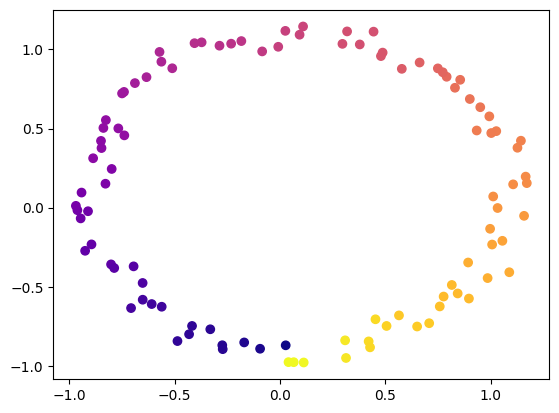

In [ ]:
plot_circular_coordinates(D,x)

#The Flat Torus

Now, to make a distance function on the flat torus, it is important to understand the quotient... or to do a function that if the distance in one of the axis is greater than $1/2$, go the other way around...

In [141]:
def flat_torus_distance(x,y):
  #both x and y are points on the flat torus, so 2 element arrays
    xdiff = abs(x[0] - y[0])
    if xdiff > (1 / 2):
        xdiff = 1 - xdiff

    ydiff = abs(x[1] - y[1])
    if ydiff > (1 / 2):
        ydiff = 1 - ydiff

    return np.sqrt(xdiff**2 + ydiff**2)

Now that we have defined the distance on the flat torus, it is quite easy to define the distance matrix (quite similar than before, but with a different distance function)

In [142]:
def points_to_distance_matrix(x):
  # x is an array of 2-element arrays
    n = len(x)
    M = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            distance = flat_torus_distance(x[i], x[j])
            M[i, j] = distance
    return M

Now we sample the points

In [106]:
n=15
t = np.linspace(0,1,n)
x,y = np.meshgrid(t,t)
x = np.reshape(x, (n*n,1))
y = np.reshape(y, (n*n,1))
X = np.hstack([x, y]) + 0.05*np.random.random((n*n,2))


We now recalculate the two most persistence points, by using this new distance matrix and then using ripser again.

In [107]:
D=points_to_distance_matrix(X)
persistence=ripser(D, coeff=41, do_cocycles=True,distance_matrix=True)
diagrams = persistence['dgms']
cocycles = persistence['cocycles']

we can not use np.argmax() as a way to find the two most persistent points (only to find the most persistent one), so we will use np.argsort to sort the persistence of the element of dgm1 and pick the two last ones.





In [108]:
dgm1 = diagrams[1]
idx1=np.argsort(dgm1[:, 1] - dgm1[:, 0], axis=0)[-1]
idx2=np.argsort(dgm1[:, 1] - dgm1[:, 0], axis=0)[-2]
c1=cocycles[1][idx1]
c2=cocycles[1][idx2]

now we plot both circular coordinates and we get exactly what we expect: vertical or horizontal gradient.  After trying with diferent thrsholds I didn't have any problem with any of them as long as they are chosen accordingly (You might pick a treshold just before the colapse of one of the two persistent points for the other and run into the problem that at that treshold, the feature is not alive).

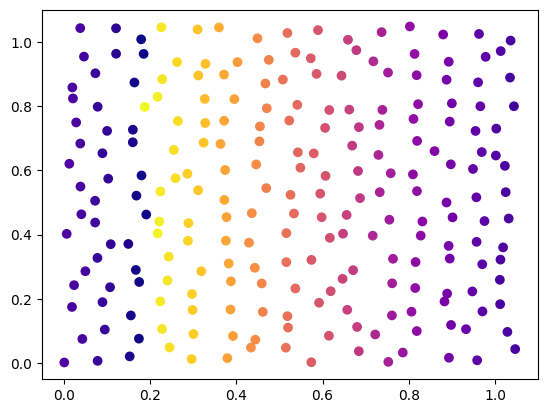

In [109]:
r1=dgm1[idx1, 1]-0.000000001

plot_circular_coordinates(D,X,c1,r1)

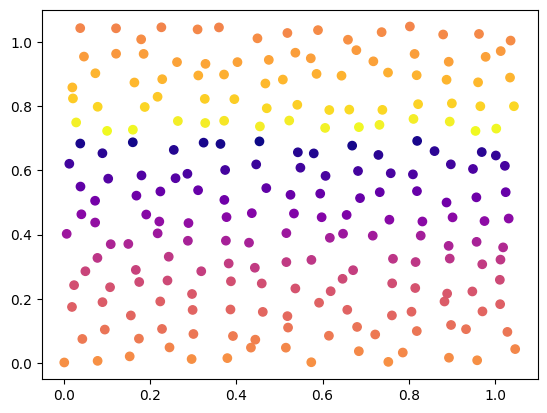

In [110]:
r2=dgm1[idx2, 1]-0.000001

plot_circular_coordinates(D,X,c2,r2)



Apart from that, after dealing a bunch of testing, it really seems like that if you chose any treshold in which the feature is alive, the circular coordiantes doesn't vary much. Moreover, I did a little bit of research (to rest asure I was not mistaken) and I found evidence on the literature of this result ( [Generalized penalty for circular coordinate representation](https://arxiv.org/pdf/2006.02554.pdf), by Luo, Hengrui and Patania, Alice and Kim, Jisu and Vejdemo-Johansson, Mikael, appendix E).

It should be noticed that sometimes, instead of an horizontal and a vertical gradient, one of the two plots is a diagonal gradient, this is because, for some reason, the base chosen is diagonal. In sight, it still makes sense, it would be as if, when going around the torus per the long side, for some reason the first path to appear goes around the torus in the other direction.

#Image Data
After downloaded and uploaded the unprocessed version (I put in a drive for easy acces), I decided to go with the duck (I just like ducks) then I realised that is not on the unprocessed version, so I just picked the one with the most "intereseting" persistent features (I ploted a persistence diagram with ripser for each and picked obj 1 that had an intereseting feature on circular coordinates). To start, we need to be able to convert the images into vectors of pixel intensities. For that we use the PIL package.

First, lets import the packages and the data

In [ ]:
from PIL import Image
import urllib
import zipfile
import os
import natsort

# I extract the data online to not have to send the file separetly

url = "https://cave.cs.columbia.edu/old/databases/SLAM_coil-20_coil-100/coil-20/coil-20-unproc.zip"
extract_dir = "./data/"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extract_dir)

data_directory = "./data/coil-20-unproc/"

Now continue by getting the names of the files, getting only the files of object 1 (or any other one), and getting the images and the vectors of those images in their respective arrays.

In [ ]:

file_names = natsort.natsorted([n for n in os.listdir(data_directory) if n.startswith("obj1")]) #change obj1 to objn (n \in [1,5]) to change the object

X_img = []
imgs = []
for file_name in file_names:    #Transform the images into vectors
    image = Image.open(data_directory + file_name)
    l, h = image.size
    imgs.append(image)
    x = np.array(image)
    X_img.append(x.reshape(x.shape[0] * x.shape[1]))

X_img = np.array(X_img)

We repeat the good all process of running ripser with the vector of the images as the points, and getting the diagrams, cocycles and distance matrix

In [ ]:
image_rips=ripser(X_img,do_cocycles=True)
diagrams = image_rips['dgms']
cocycles = image_rips['cocycles']
D_img = image_rips['dperm2all']   # we get the distance matrix from ripser to use it on the ploting

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


We compute the persistence diagram (we have used it to see that there is, in fact, a persistent enough feature to be interesting)

<ipython-input-38-0ed207447add>:4: MatplotlibDeprecationWarning: Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')


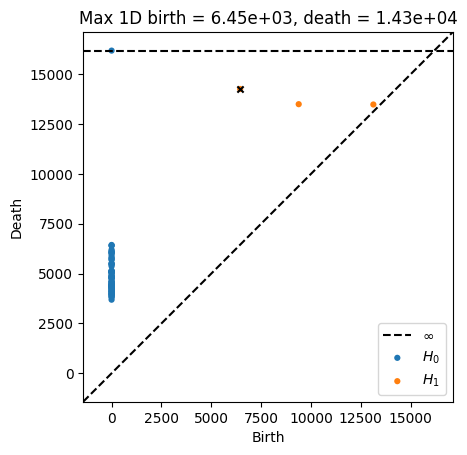

In [ ]:
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

Now we will produce a plot with the circular coordinates, we first get the circular coordinates of every image, since we sorted the images beforehand we don't need to swap any order. Then we plot every single image with the circular coordiantes as the title so one can see that in fact, the algorithm understand that the images are "points around the hole", as intended.

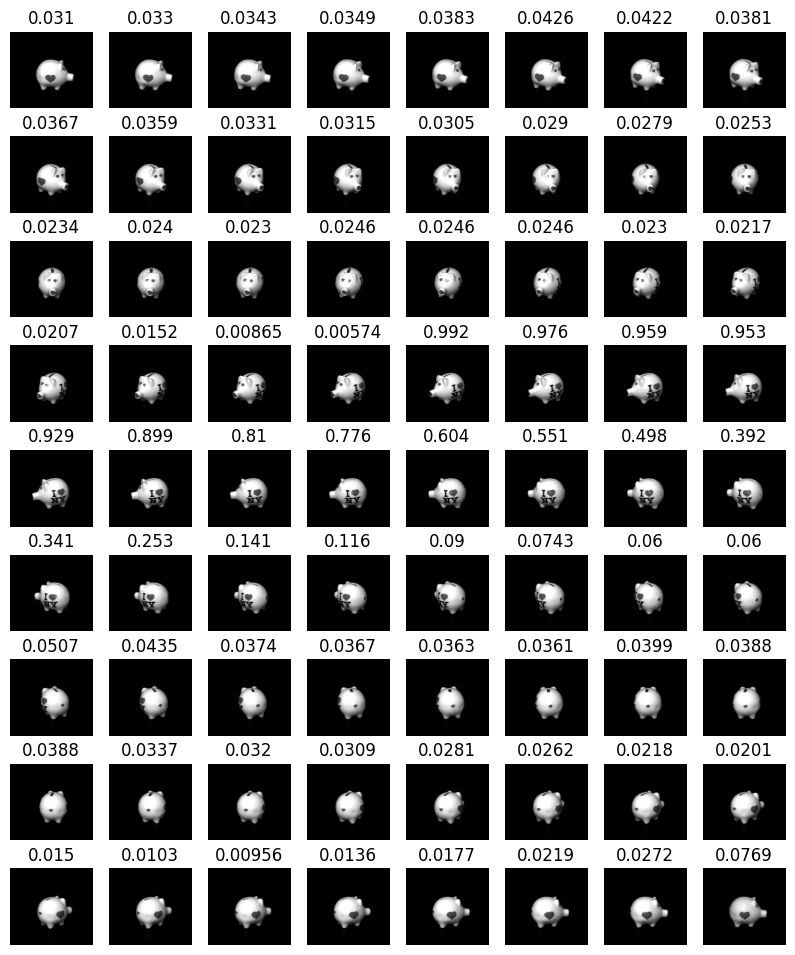

In [ ]:
cc_img=circular_coordinates(D_img)



f, axs = plt.subplots(9, 8, figsize=(10, 12))
for i in range(9):
    for j in range(8):
        index= i*8+j
        axs[i, j].imshow(imgs[index],cmap="gray")
        cc="{:.3g}".format(cc_img[index])
        axs[i, j].set_title(cc)
        axs[i, j].axis("Off")

plt.show()

As we can see, this image in particular goes back and forth in circular coordiantes, and this is because the front and the back of the piggy look quite similar, so even if the rotation of the camera is at very different angles, the position as the images as vectors in relation to the "hole" in between of the 72 images, is quite close. This is even more evident on the next part, when we perform the PAC to the points and see that some of them are more like an eight than a circle.

##Image Data 2: All images simultaneously

Now we have to et back not only the 72 images of our object but the 72 images of every one of the 5 objects. We basically repeat the same code, but not filtering which elements we get.

In [55]:
file_names_all = natsort.natsorted([n for n in os.listdir(data_directory)] ) # we get rid off the "if" condition

X_img_all = []
imgs_all = []
for file_name in file_names_all:    #Transform the images into vectors
    image = Image.open(data_directory + file_name)
    l, h = image.size
    imgs_all.append(image)
    x = np.array(image)
    X_img_all.append(x.reshape(x.shape[0] * x.shape[1]))

X_img_all = np.array(X_img_all)

Now we compute ripser to get distance matrix and the persistence diagram

In [56]:
all_rips=ripser(X_img_all,do_cocycles=True)
diagrams_all = all_rips['dgms']
cocycles_all = all_rips['cocycles']
D_all = all_rips['dperm2all']   # we get the distance matrix from ripser to use it on the ploting

/usr/local/lib/python3.11/dist-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


We plot the persistence diagram. Always nice to know what is going on and to check that we get the correct values.

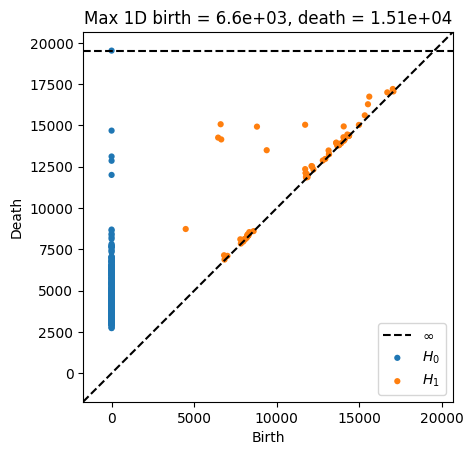

In [57]:
dgm1 = diagrams_all[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams_all, show = False)
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

We then get the 5 pairs $(x,y)$ that maximise the value of $\frac{y-x}{x}$ with argsort. Now features has the 5 indices in diagrams that are important. We then use this 5 elements to calculate 5 cocycles and the 5 different circular coordinates

In [65]:
features=np.argsort((dgm1[:, 1] - dgm1[:, 0])/dgm1[:, 0])[-5:]





cocycle1=cocycles_all[1][features[0]]
cocycle2=cocycles_all[1][features[1]]
cocycle3=cocycles_all[1][features[2]]
cocycle4=cocycles_all[1][features[3]]
cocycle5=cocycles_all[1][features[4]]

CC_1=circular_coordinates(D_all,cocycle1, r = dgm1[features[0], 0]+1)
CC_2=circular_coordinates(D_all,cocycle2, r = dgm1[features[1], 0]+1)
CC_3=circular_coordinates(D_all,cocycle3, r = dgm1[features[2], 0]+1)
CC_4=circular_coordinates(D_all,cocycle4, r = dgm1[features[3], 0]+1)
CC_5=circular_coordinates(D_all,cocycle5, r = dgm1[features[4], 0]+1)

Now we proceed to import PCA from sklearn and do a PCA of the points

In [66]:
from sklearn.decomposition import PCA

X_pca=PCA(n_components=2).fit_transform(X_img_all)


Now we make 5 scatter plots color-coded each with a different set of circular coordinates:

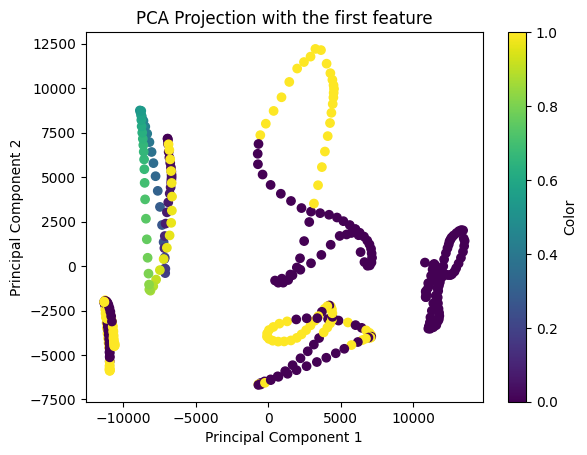

In [67]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=CC_1, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with the first feature')
plt.colorbar(label='Color')
plt.show()

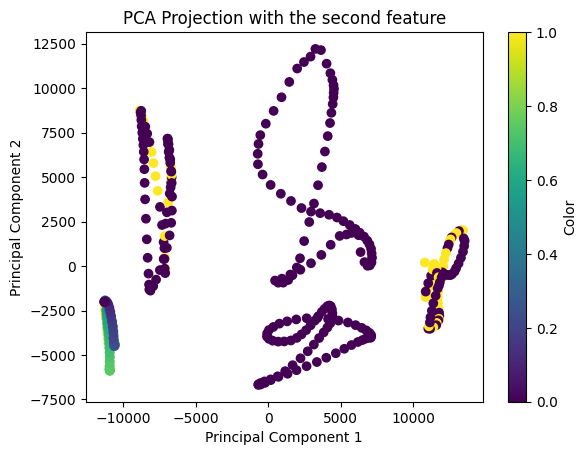

In [68]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=CC_2, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with the second feature')
plt.colorbar(label='Color')
plt.show()

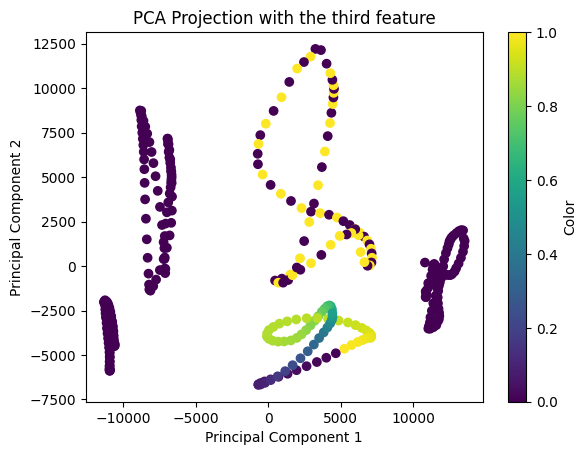

In [69]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=CC_3, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with the third feature')
plt.colorbar(label='Color')
plt.show()

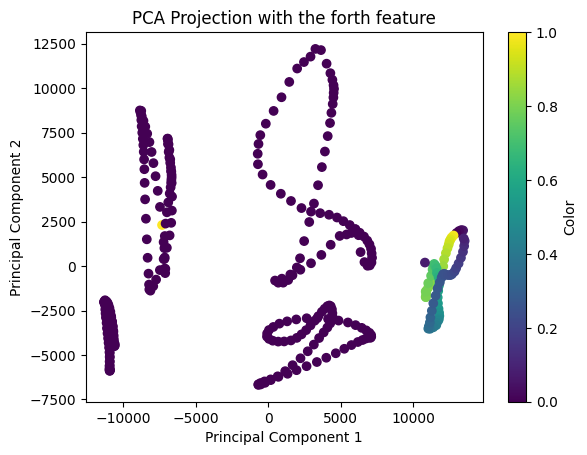

In [70]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=CC_4, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with the forth feature')
plt.colorbar(label='Color')
plt.show()

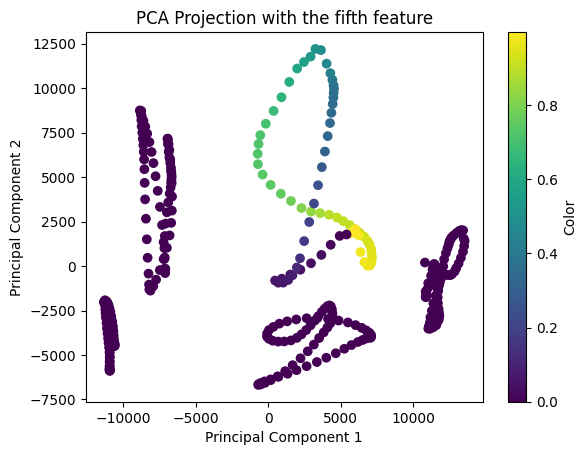

In [71]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=CC_5, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection with the fifth feature')
plt.colorbar(label='Color')
plt.show()

As we can see, PCA is quite effective on separating the 5 different objects into clusters. Moreover, ploting the circular coordinates it is easy to see that the different holes are well identified by the different set of circular coordinates

#Surprise me

note: I expended a lot of time looking for a good dataset with interesting topological features just to read back the exercise and see that we are the ones that should construct the data set. In the end I opted for doing both, using a datset of shapes from openml.datasets, inspired by the images, and a second with a dataset constructed by me.

Start by importing the datest that consist of pointclouds from real-world objects (from princeton course https://www.cs.princeton.edu/courses/archive/fall09/cos429/assignment3.html). The version we got through OpenML only has 40 models (4 classes 10 objects each)

In [111]:
!pip install openml
from openml.datasets.functions import get_dataset

df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]


now, the same way that we treate every image as a vector, we can make an array of entries where each entry is a point cloud:

In [133]:
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique() #to make sure we don't enter the same point multiple times
    ]
)
point_clouds.shape

(40, 400, 3)

What I wanted to achieve, was an implementation that you give it any value (between 0 and 39), and it returns a 3d scatter plot that highlights the circular coordinates of the most persistent 1 dimension feature. It not only seems intuitive to better visualize the "holes" of the structure, but it is just the next step in the implementation.

First we define a function that calculates ripser and might plot it if you ask, it return diagrams[1], cocycles[1] and the distance matrix D.

In [134]:
def calculate_ripser(X, plot=False):
  rips=ripser(X,do_cocycles=True)
  diagrams = rips['dgms']
  cocycles = rips['cocycles']
  D = rips['dperm2all']
  if plot==True:
    dgm1 = diagrams[1]
    idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
    plot_diagrams(diagrams, show = False)
    plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
    plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
    plt.show()
  return diagrams[1], cocycles[1], D

Then we make a function that given a set of points, it gets a 3D plot with the circular coordinates

In [135]:
def plot_3d_circular_coordinates(X, D=False, cocycle=False, r=False, p=41, norm="linear", diagram=False):
  if isinstance(D,bool):
    diagram, cocycles, D=calculate_ripser(X,plot=diagram)

  coordinates = circular_coordinates(D, cocycle, r, p)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=coordinates, cmap="plasma", norm=norm)

  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  plt.show()

Now we can just set any number and it will plot the point cloud and its most representative circular coordinates:

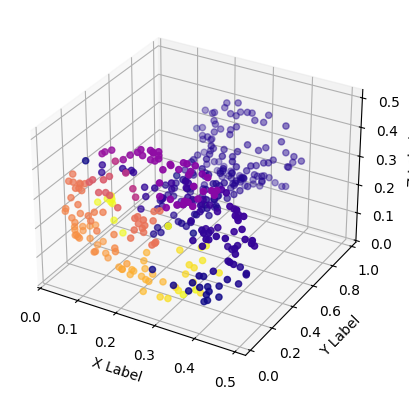

In [138]:
i = 15 #feel free to change i from 0 to 39, it is quite nice to see one from each 0~9, 10~19, 20~29 and 30~39


diagram, cocycles, D=calculate_ripser(point_clouds[i])
idx = np.argmax(diagram[:, 1] - diagram[:, 0])


plot_3d_circular_coordinates(point_clouds[i], r=diagram[idx, 0]+0.00001, diagram=False)

in here we can see one of the features of the circular coordinates: sometimes the most persistent feature is not centric to the pointcloud. This gives less information of the pointcloud overall but makes it really easy to identify the mots persistent feature. Some may say that this is a weakness but it is a good tool to get together with persistence homology to find this persistent features when looking back at the data and seeing what generates them.

The next implementation is going to be from the Flat Torus, but instead of just aplying circular coordinates again, we are going to use the circular coordinates to see that we can reconstruct the original position of the points in the surface of a flat torus by its circular coordinates. We start by remaking the flat torus: To better see that this preserves structure, we are going to poke some holes in the flat torus (small enough so that the most persistent features are still the 2 main holes)

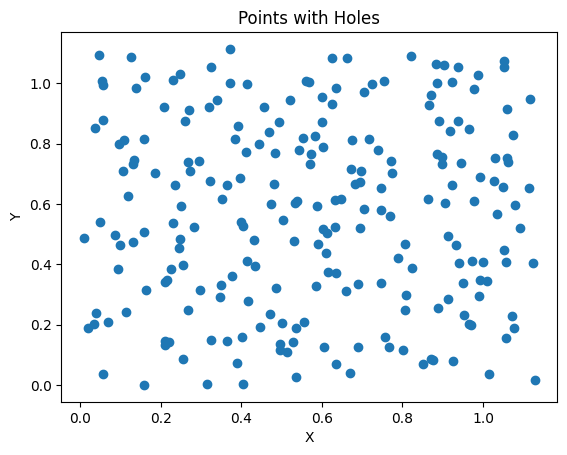

NameError: name 'torus_distance_matrix' is not defined

In [139]:

from sklearn.cluster import DBSCAN

# Define parameters
n = 16  # grid size
num_holes = 4  # number of holes
min_samples = 15  # minimum number of samples in a cluster
epsilon = 1  # maximum distance between samples in a cluster
max_points_per_hole = 30  # maximum number of points to remove per hole

# Create grid points
t = np.linspace(0, 1, n)
x, y = np.meshgrid(t, t)
x = np.reshape(x, (n*n, 1))
y = np.reshape(y, (n*n, 1))

# Add noise to grid points
X = np.hstack([x, y]) + 0.15 * np.random.random((n*n, 2))

# Create DBSCAN clustering model
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

# Fit the model and predict clusters
clusters = dbscan.fit_predict(X)

# Identify points in clusters
cluster_indices = {}
for i, cluster_id in enumerate(clusters):
    if cluster_id != -1:  # -1 indicates noise points
        if cluster_id not in cluster_indices:
            cluster_indices[cluster_id] = []
        cluster_indices[cluster_id].append(i)

# Remove points from clusters to create holes
holes_created = 0
for cluster_id, indices in cluster_indices.items():
    if holes_created >= num_holes:
        break
    if len(indices) <= max_points_per_hole:
        X[indices] = np.nan
        holes_created += 1
    else:
        np.random.shuffle(indices)
        indices_to_remove = indices[:max_points_per_hole]
        X[indices_to_remove] = np.nan
        holes_created += 1

# Remove NaN values
X = X[~np.isnan(X).any(axis=1)]

# Visualize the points
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Points with Holes')
plt.show()

# and now make the persistence diagram
D=torus_distance_matrix(X)
image_rips=ripser(D,do_cocycles=True, distance_matrix=True)
diagrams = image_rips['dgms']
cocycles = image_rips['cocycles']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

And calculating the circulate coordinates of its two most persistent points

In [140]:
D=torus_distance_matrix(X)
persistence=ripser(D, coeff=41, do_cocycles=True,distance_matrix=True)
diagrams = persistence['dgms']
cocycles = persistence['cocycles']
dgm1 = diagrams[1]
idx1=np.argsort(dgm1[:, 1] - dgm1[:, 0], axis=0)[-1]
idx2=np.argsort(dgm1[:, 1] - dgm1[:, 0], axis=0)[-2]
c1=cocycles[1][idx1]
c2=cocycles[1][idx2]

NameError: name 'torus_distance_matrix' is not defined

Now lets plot the flat torus using its default coordinates and its circular coordinates:

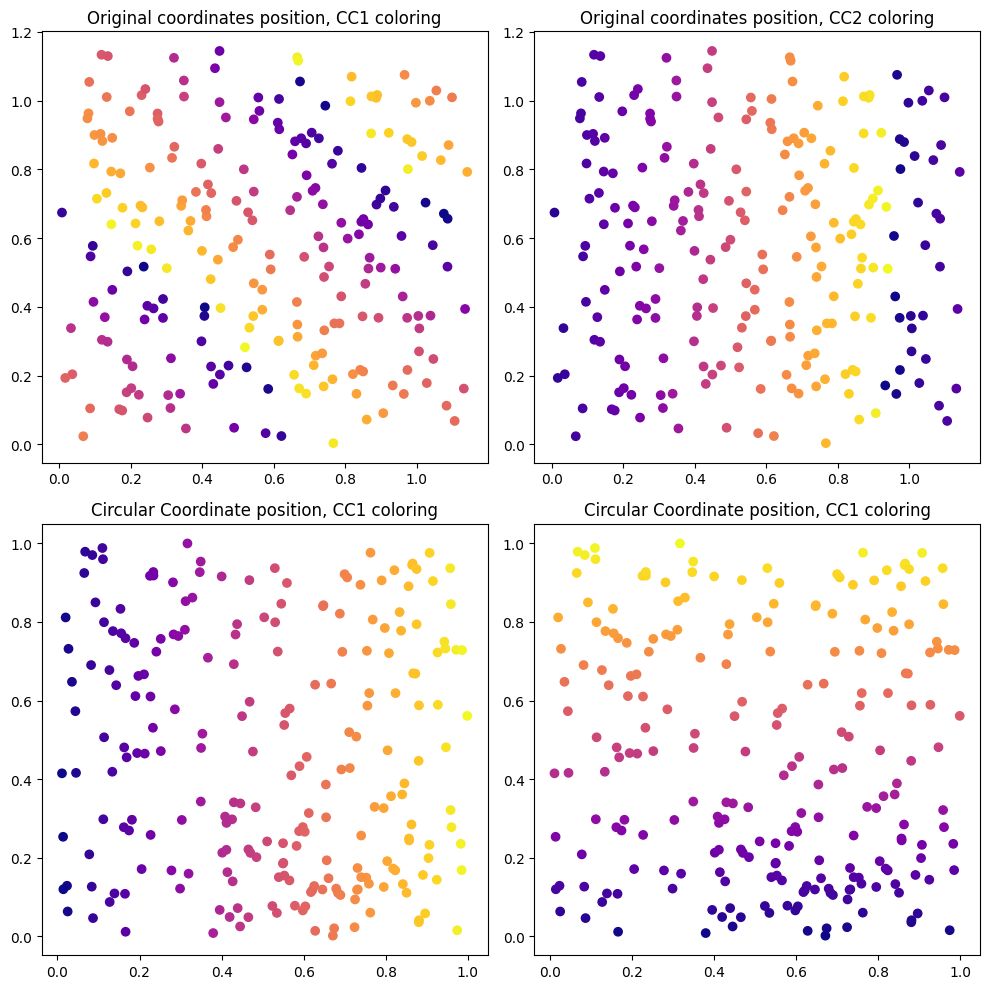

In [ ]:
coordinates1 = circular_coordinates(D, c1)
coordinates2 = circular_coordinates(D, c2)


# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the first subplot
axs[0, 0].scatter(X[:, 0], X[:, 1], c=coordinates1, cmap="plasma")
axs[0, 0].set_title('Original coordinates position, CC1 coloring')

# Plot the second subplot
axs[0, 1].scatter(X[:, 0], X[:, 1], c=coordinates2, cmap="plasma")
axs[0, 1].set_title('Original coordinates position, CC2 coloring')

# Plot the third subplot
axs[1, 0].scatter(coordinates1[:], coordinates2[:], c=coordinates1, cmap="plasma")
axs[1, 0].set_title('Circular Coordinate position, CC1 coloring')

# Plot the fourth subplot
axs[1, 1].scatter(coordinates1[:], coordinates2[:], c=coordinates2, cmap="plasma")
axs[1, 1].set_title('Circular Coordinate position, CC1 coloring')

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

With this, what it should be noticed is that, even if  swapping axis, or directions (and on the unfortunate case that one of the two circular coordinates is diagonal a little of tilting), most of the torus structure is preserved.